# Amazon Recommender System

## 0- Import Libraries we are going to use.

### Frameworks and libraries to use:
- numpy and pandas: standard libraries to read datasets and perform a wide variety of mathematical operations.

- matplotlib and seaborn: standard visualization libraries

- surprise: a scikit extension that is made for the soul purpose of building recommender systems.

In [2]:
import numpy as np
import pandas as pd
from surprise import SVD,KNNWithMeans,Reader,Dataset,accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split  
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import mplcyberpunk
import random
from collections import defaultdict


## 1- Load Dataset and add column titles

#### From the start we discover that the dataset is missing its column name/title.
#### Therfore we are going to use the titles found on Kaggle.

In [3]:
df=pd.read_csv("ratings_Electronics (1).csv",names=["UserId","ProductId","Rating","TimeStamp"])
df.head()

,UserId,ProductId,Rating,TimeStamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


## Choosing Recommender System Approach

### Looking at the data available, the best technique is Collaborative Filtering (CF)

##### Collaborative Filtering is predicting the interests of users based on their past interactions with items, as well as the interactions of other similar users. 
##### If User A is similar to User B and User B rates product P 5/5, this means that User A might like product P.
##### Collaborative filtering works best when you do not have alot of categorical data that may emphasize the taste of this user and only have the ratings of users to the items such as this dataset.

## Analyzing the data

In [4]:
df.shape

(7824482, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   TimeStamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [6]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)) #to remove scientific notation


,Rating,TimeStamp
count,7824482.00000,7824482.00000
mean,4.01234,1338178197.27241
std,1.38091,69004257.78659
min,1.00000,912729600.00000
25%,3.00000,1315353600.00000
50%,5.00000,1361059200.00000
75%,5.00000,1386115200.00000
max,5.00000,1406073600.00000


##### No null values

In [7]:
df.isnull().sum()

UserId       0
ProductId    0
Rating       0
TimeStamp    0
dtype: int64

##### Remove Timestamp column as we don't have sufficient information about it

In [7]:
df.drop(columns=["TimeStamp"],inplace=True)

##### No in-between ratings like 4.5 or 2.5 which is convenient when visualizing

In [8]:
df.Rating.value_counts()

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: Rating, dtype: int64

In [9]:
print(f"Number of unique users: {df.UserId.nunique()} out of {df.shape[0]}")
print(f"Number of unique items: {df.ProductId.nunique()} out of {df.shape[0]}")

Number of unique users: 4201696 out of 7824482
Number of unique items: 476002 out of 7824482


## Visualizations

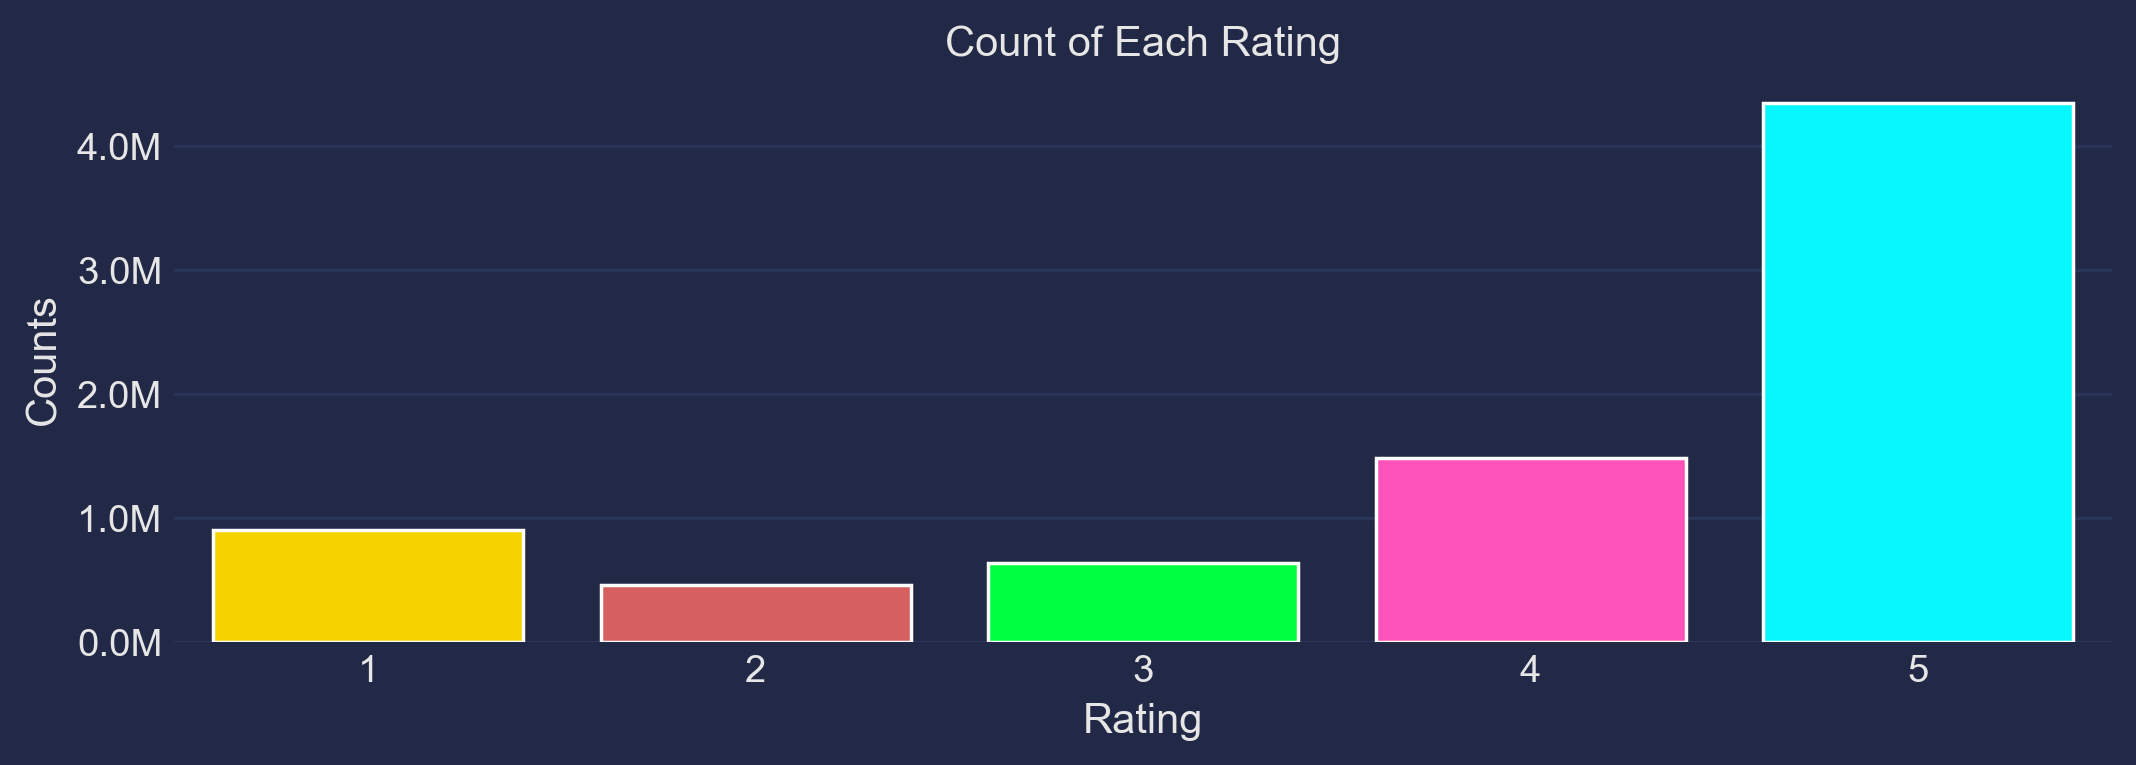

In [10]:
colors=["#f5d300","#d65f5f","#00ff41","#fe53bb","#08f7fe"]
sns.set_theme( palette="muted")
plt.style.use("cyberpunk")
plt.figure(figsize=(10,3), 
           dpi = 250) 
hist=sns.countplot(data=df,x="Rating")
mplcyberpunk.add_gradient_fill(hist,alpha_gradientglow=1)
mplcyberpunk.make_lines_glow(hist,n_glow_lines=30)
for i, patch in enumerate(hist.patches):
    patch.set_facecolor(colors[i])
x_ticks=range(1,6)
hist.set_xticks(range(len(x_ticks)),labels=x_ticks)
hist.set_ylabel("Counts")
fmt = lambda x, pos: '{:.1f}M'.format(x/1000000)
yticks = mtick.FuncFormatter(fmt)
plt.title("Count of Each Rating")
plt.gca().yaxis.set_major_formatter(yticks)

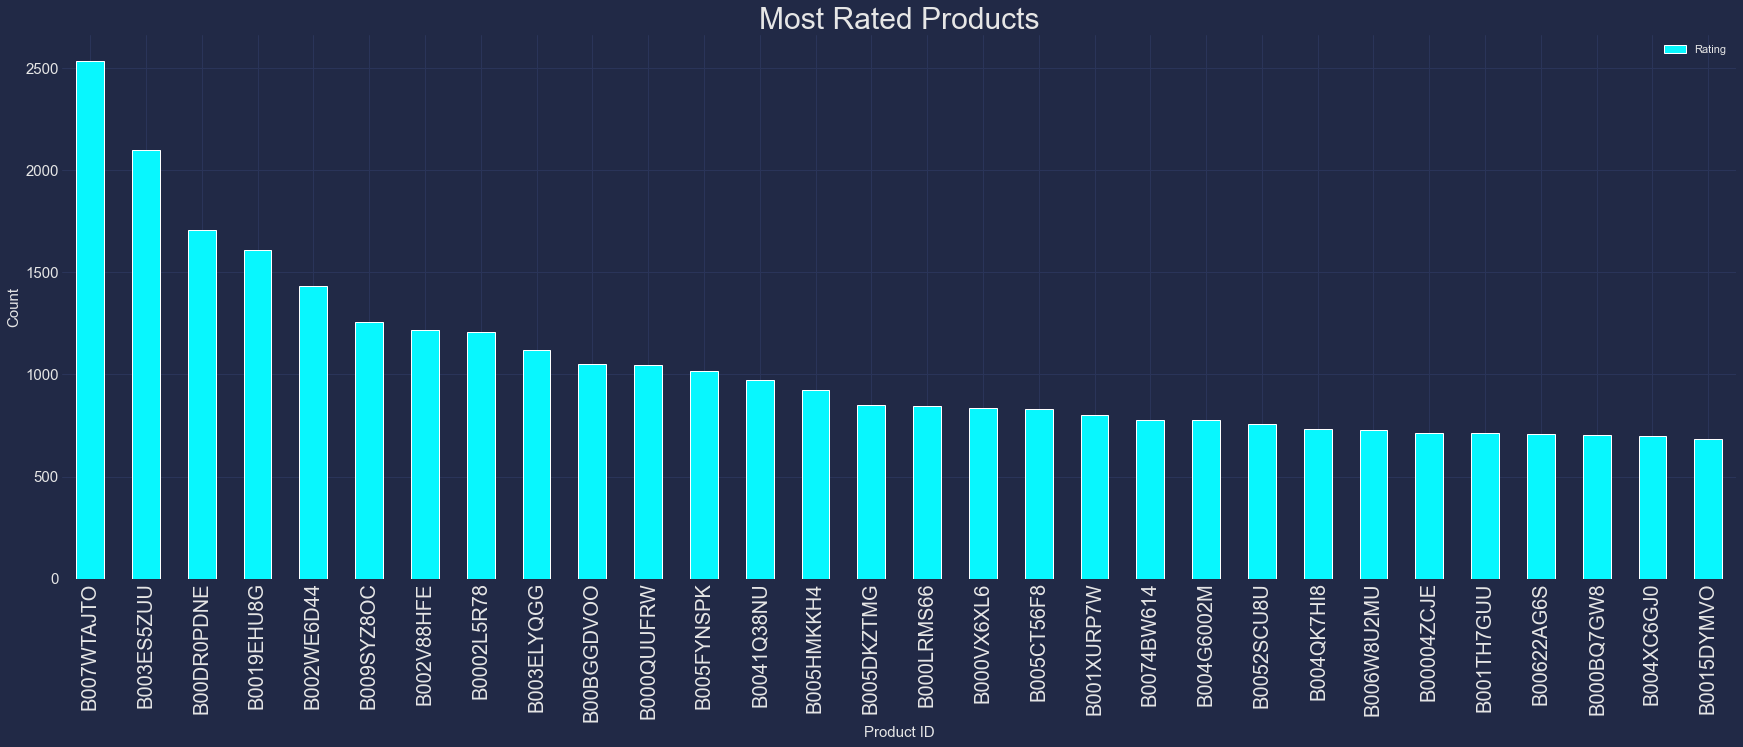

In [138]:
popular_products = pd.DataFrame(df.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar",figsize=(30,10))
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.title("Most Rated Products",fontsize=30)
plt.xlabel("Product ID",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.show()


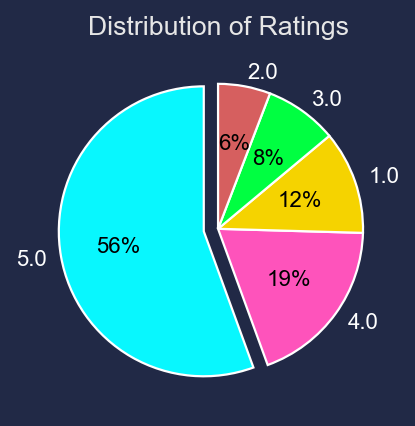

In [11]:
values=list(df.Rating.value_counts())
labels=list(df.Rating.value_counts().index)
plt.figure(figsize=(10,3), 
           dpi = 160) 
plt.title("Distribution of Ratings")
_,_,autotexts= plt.pie(values,labels=labels,autopct='%1.f%%',startangle=90,explode=(0.1, 0.0, 0.0, 0.0,0.0),textprops={'fontsize': 10,"color":'white'})
for autotext in autotexts:
    autotext.set_color('black')

##### About 75% of users vote 4.0 or higher for Amazon's products which is impressive.

### Let's Analyze the Users Column

#### Users with most amount of ratings submitted

In [12]:
df.UserId.value_counts()[:10]

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
Name: UserId, dtype: int64

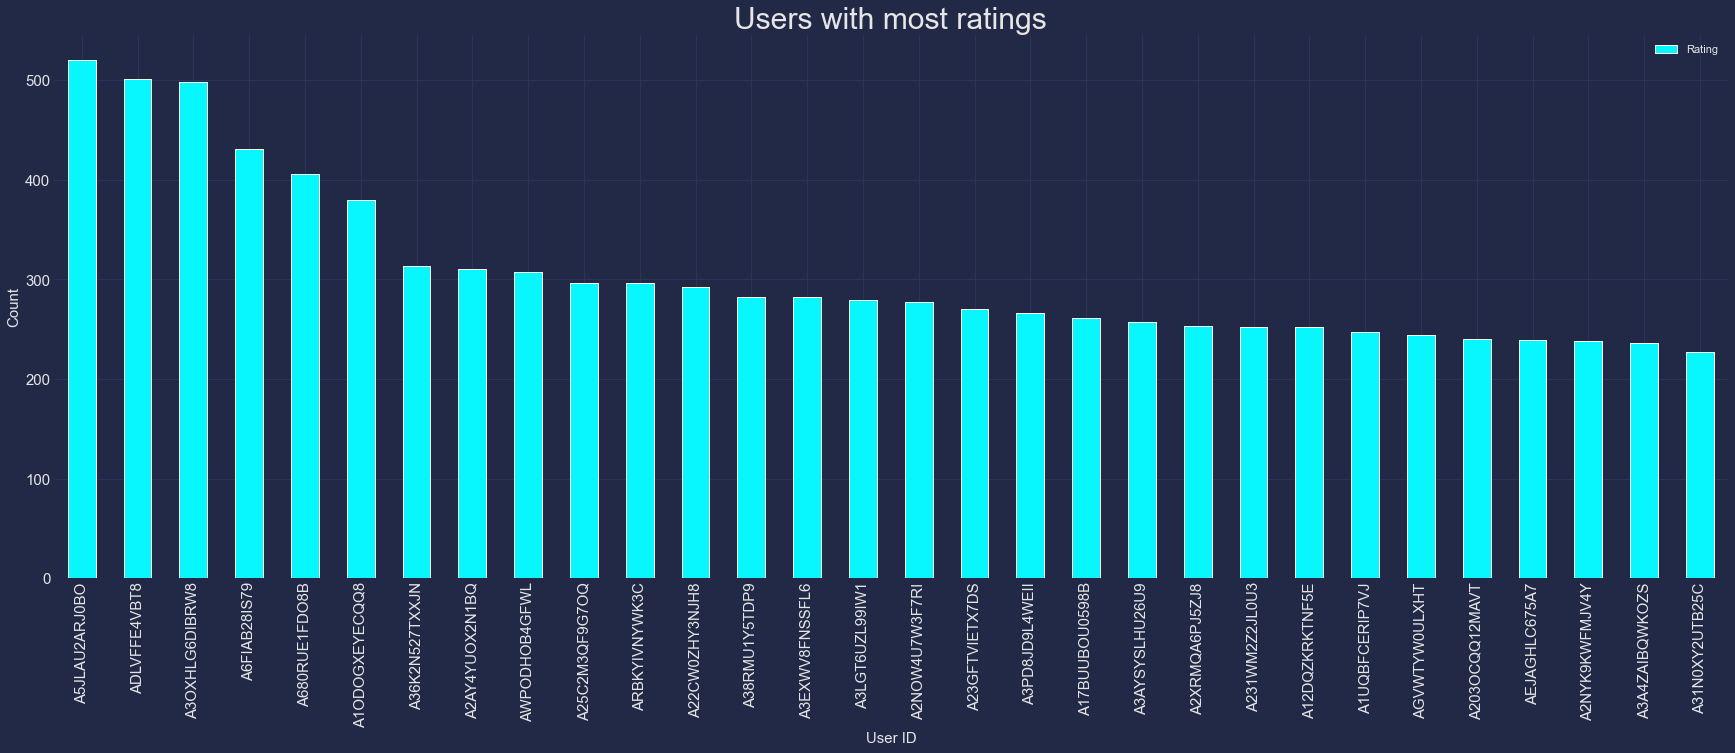

In [140]:
popular_products = pd.DataFrame(df.groupby('UserId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar",figsize=(30,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Users with most ratings",fontsize=30)
plt.xlabel("User ID",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.show()


### This shows that users really vote alot on Amazon, but do not let this deceive you

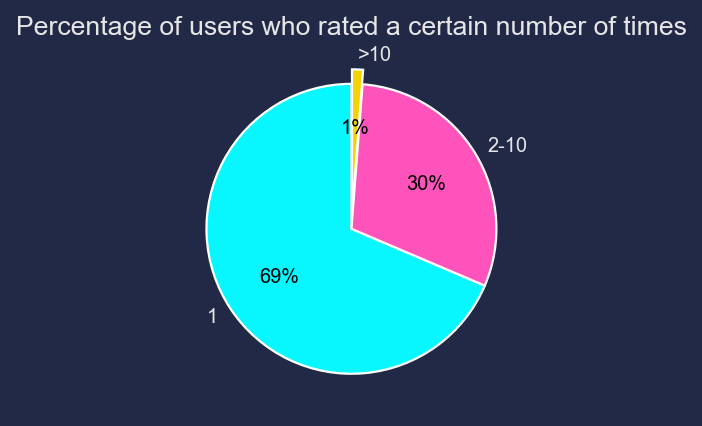

In [13]:
count=df.UserId.value_counts()
one=(count==1).sum()
two_ten=((count>1) & ( count<=10 )).sum()
rest=(count>10).sum()
plt.figure(figsize=(10,3), 
           dpi = 160) 
plt.title("Percentage of users who rated a certain number of times")
_,_,autotexts=plt.pie([one,two_ten,rest],labels=["1","2-10",">10"],autopct='%1.f%%',startangle=90,explode=(0.0, 0.0, 0.1),textprops={'fontsize': 9})
for autotext in autotexts:
    autotext.set_color('black')

### Around 70% of users only voted once which will cause some issues when building our recommender later

# Modeling

### There are two famous methods to make a CF recommendation system:

####            - Matrix factorization: This algorithm aims to factorize a large matrix of user-item interactions into two smaller matrices: one for users and one for items. The algorithm then uses these matrices to predict missing ratings and make recommendations.

####            - Nearest neighbor techniques: The algorithms use a similarity metric to identify users who are most similar to the target user and then recommend items that the similar users have interacted with.

##### Note: There are other techniques but these are the ones we are going to use.

# ----------------------------------------------------------------------------

#### For our recommender system to be accurate, we will only select the users who have made 10 or more ratings

In [15]:
users=df["UserId"].value_counts()
users=users[users>=10]
df=df.loc[df.UserId.isin(users.index)]


##### Read the data to the surprise library

In [16]:
# To have unbaised predictions we have to manually split the train and test datasets.
read=Reader()
data=Dataset.load_from_df(df,reader=read)

raw_data=data.raw_ratings
random.shuffle(raw_data)

#train 80% test 20% as we have 1.0M samples
threshold=int(0.8*len(raw_data))
train_data=raw_data[:threshold]
test_data=raw_data[threshold:]

#### We manually separate the train and test because surprise converts the train and test sets from "Dataset" objects to "Trainset" and "Testset" objects.
#### So we manually do it because GridSearching only accepts "Dataset" objects and since we cannot send the entire dataset because we need unseen data (aka testset), we have to separate them manually.

In [17]:
def get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for userID, productID, _, est, _ in predictions:
        top_n[userID].append((productID, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n #dict keys are userid an value of list of tuples

In [18]:
def print_recommendations(userID,predictions,n=10):
    recommendations=get_top_n(predictions,n)
    # Remove ratings already made by the user but leave predicted ones
    for tup in recommendations[userID]:
        if (df.isin({'UserID':userID,"ProductID":tup[0]}).all(axis=None)) :
            recommendations.remove(tup)
        
    print(f"Recommended products for user:{userID}\n")
    sentence="Product: {},\tPredicted Rating: {}\n"
    for tup in recommendations[userID]:
        print(sentence.format(tup[0],tup[1]))

## Matrix Factorization: (SVD)


#### GridSearching best parameters

In [19]:
data.raw_ratings=train_data #data is now training data


# Define parameter grid for GridSearchCV
params = {
    "n_epochs": [5, 10, 15, 20],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6]
}

# Perform grid search using SVD algorithm
SVD_model = GridSearchCV(SVD, params, n_jobs=-1, measures=['rmse'])
SVD_model.fit(data)

# Print best score, best parameters, and best estimator
print(SVD_model.best_score['rmse'])
print(SVD_model.best_params['rmse'])
print(SVD_model.best_estimator['rmse'])



1.093927900771916
{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.4}


#### Retraining the best model on "Trainset" object

In [20]:
best_SVD_model=SVD_model.best_estimator["rmse"]
trainset=data.build_full_trainset()
best_SVD_model.fit(trainset)

#### Testing on "Testset" object

In [21]:
testset = data.construct_testset(test_data)  # testset is now the set B
predictions = best_SVD_model.test(testset)
print("Unbiased accuracy RMSE ", end=" ")
accuracy.rmse(predictions,verbose=False)


Unbiased accuracy RMSE  

1.0891106378575934

###  Get the top-10 recommendations for random user from the testset

In [70]:
userID='A5JLAU2ARJ0BO'
print_recommendations(userID,predictions)

Recommended products for user:A5JLAU2ARJ0BO

Product: B001P05NBA,	Predicted Rating: 4.442487106159817

Product: B00005LEN4,	Predicted Rating: 4.435326688320076

Product: B0000C8817,	Predicted Rating: 4.408817717721971

Product: B000AV14M2,	Predicted Rating: 4.3484063484509745

Product: B000ACHVVE,	Predicted Rating: 4.335057479938152

Product: B0036Q7MV0,	Predicted Rating: 4.315950200035789

Product: B0000X0VCY,	Predicted Rating: 4.315763579215798

Product: B00083JQY0,	Predicted Rating: 4.310871405644201

Product: B00FJRS5BA,	Predicted Rating: 4.295399316413413

Product: B0000AINEH,	Predicted Rating: 4.28443561112893



## Nearest Neighbor Technique: (KNNWithMean)

##### As KNN is not a memory efficient algorithm such as SVD we are going to limit the algorithm to 50K samples

In [64]:
read=Reader()
data=Dataset.load_from_df(df.sample(50000),reader=read) 

raw_data=data.raw_ratings
random.shuffle(raw_data)

#train 80% test 20% as we have 1.0M samples
threshold=int(0.7*len(raw_data))
train_data=raw_data[:threshold]
test_data=raw_data[threshold:]

#### GridSearching best parameters

In [24]:
sim_options = {
    "name": ["cosine", "msd", "pearson"],
    "min_support": [3, 4, 5],
    "user_based": [True,False]
}
params = {"k":range(10,15,1) ,'sim_options': sim_options}
model = GridSearchCV(KNNWithMeans, params, measures=['rmse'])
model.fit(data)
print(model.best_score)
print(model.best_params)
print(model.best_estimator)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

#### Retraining the best model on "Trainset" object

In [66]:
trainset=data.build_full_trainset()
KNN_model=model.best_estimator["rmse"]
KNN_model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


##### Test the model

In [67]:
testset = data.construct_testset(test_data) 
KNN_predictions = best_SVD_model.test(testset)
print("Unbiased accuracy RMSE ", end=" ")
accuracy.rmse(KNN_predictions,verbose=False)

Unbiased accuracy RMSE  

0.9625571330864885

### Get predictions for the same random user from the testset

##### Note: The predictions are different from SVD predictions because it is running on a much smaller dataset

In [71]:
print_recommendations(userID,KNN_predictions)

Recommended products for user:A5JLAU2ARJ0BO

Product: B0001A06GW,	Predicted Rating: 4.291679282295229

Product: B000DZFTZS,	Predicted Rating: 4.228464494720003

Product: B00007E8YT,	Predicted Rating: 4.1960668741227725

Product: B0041O42BE,	Predicted Rating: 4.133986995554817

Product: B0000D8HAD,	Predicted Rating: 4.113286019355563

Product: B000233YDK,	Predicted Rating: 3.9724013299812917

Product: B000BKN2Y0,	Predicted Rating: 3.9250270775058627

Product: B00BZC31WQ,	Predicted Rating: 3.867677329867005

Product: B0001WV6YQ,	Predicted Rating: 3.831661104573468



In [106]:
sns.countplot(x=predictions[0])

AttributeError: 'bool' object has no attribute 'all'

In [32]:
def twoSum(nums, target):
        """
        :type nums: List[int]
        :type target: int
        :rtype: List[int]
        """
        sorted_list=sorted(nums)
        i=0
        j=1
        for i in range(len(nums)):
            if(sorted_list[i]+sorted_list[j]<target):
                j+=1
            elif(sorted_list[i]+sorted_list[j]>target):
                i+=1
            else:
                return[nums.index(sorted_list[i]),nums.index(sorted_list[j])]
        return[nums.index(sorted_list[i]),nums.index(sorted_list[j])]

In [31]:
twoSum([3,2,4],6)

IndexError: list index out of range